# ベイズ線形回帰

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [2]:
# データを作成
n = 1000

from scipy.stats import multivariate_normal
mean = np.array([3, 5])
Sigma = np.array([
    [1, 0.5],
    [0.5, 2],
])
X = multivariate_normal.rvs(mean=mean, cov=Sigma, size=n, random_state=0)

import statsmodels.api as sm
X = sm.add_constant(X)

# 真のパラメータ
beta = np.array([2, 3, 4])

## データが均一分散の場合

In [3]:
# 均一分散の場合
e = np.random.normal(loc=0, scale=1, size=n)
y = X @ beta + e

In [4]:
# 頻度主義
import statsmodels.api as sm
ols = sm.OLS(y, X).fit(cov_type="HC1")
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 2.622e+04
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:22:40   Log-Likelihood:                -1403.1
No. Observations:                1000   AIC:                             2812.
Df Residuals:                     997   BIC:                             2827.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1239      0.129     16.407      0.000       1.870       2.378
x1             2.9945      0.035     85.396      0.000       2.926       3.063
x2             3.9798      0.024    163.164      0.000       3.932       4.028
==============================================================================
Omnibus:                        3.544   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                3.505
Skew:                           0.115   Prob(JB):                        0.173
Kurtosis:                       2.823   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


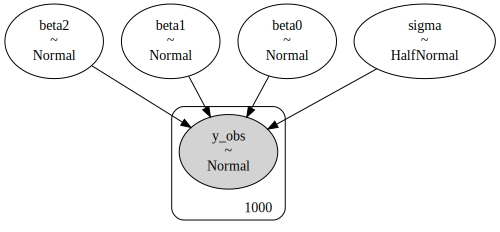

In [5]:
import pymc as pm
import arviz as az

model = pm.Model()
with model:
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)  # 分散なので非負の分布を使う

    # 平均値 mu
    mu = beta0 + beta1 * X[:, 1] + beta2 * X[:, 2]
    # 観測値をもつ確率変数は_obsとする
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

# モデルをGraphvizで表示
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


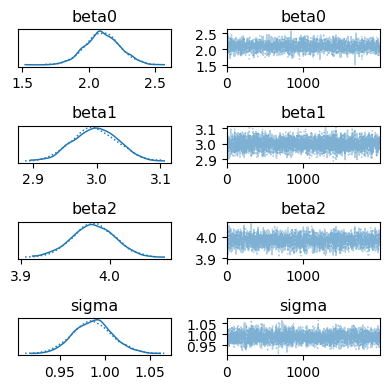

In [6]:
# ベイズ線形回帰モデルをサンプリング
with model:
    idata = pm.sample(
        chains=2,
        tune=1000, # バーンイン期間の、捨てるサンプル数
        draws=2000, # 採用するサンプル数
        random_seed=0,
    )

# 各chainsの結果を表示
az.plot_trace(idata, figsize=[4, 4])
plt.tight_layout()
plt.show()

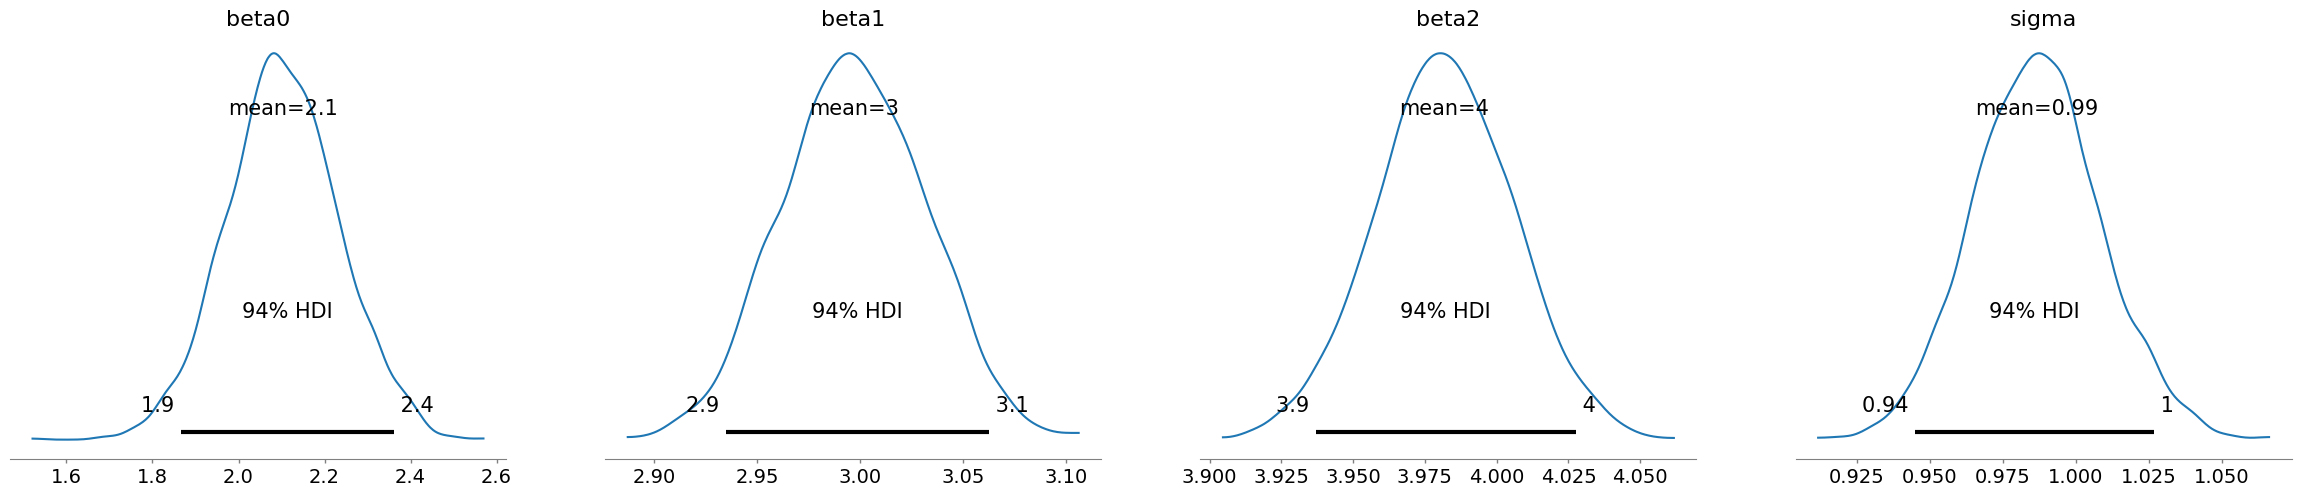

In [7]:
az.plot_posterior(idata)
plt.show()

## データが不均一分散の場合

In [8]:
# 不均一分散の場合
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

sigma = 1 + normalize(X[:, 1] + X[:, 2]) * 3
e = np.random.normal(loc=0, scale=sigma, size=n)
y = X @ beta + e

### 頻度主義 & 不均一分散に頑健な誤差推定

In [9]:
# 頻度主義
import statsmodels.api as sm
ols = sm.OLS(y, X).fit(cov_type="HC1")
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     3619.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:22:57   Log-Likelihood:                -2333.1
No. Observations:                1000   AIC:                             4672.
Df Residuals:                     997   BIC:                             4687.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6243      0.325      5.005      0.000       0.988       2.260
x1             2.9916      0.088     34.082      0.000       2.820       3.164
x2             4.0861      0.062     65.520      0.000       3.964       4.208
==============================================================================
Omnibus:                       16.923   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.027
Skew:                           0.120   Prob(JB):                     1.35e-06
Kurtosis:                       3.769   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

↑ 切片の推定にバイアスが入っている

### 均一分散を想定したベイズ線形回帰

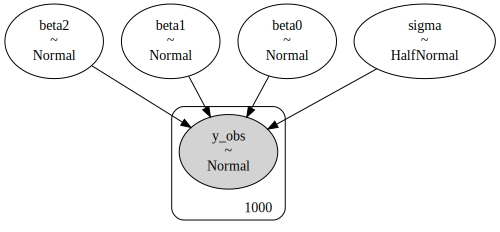

In [10]:
import pymc as pm
import arviz as az

model = pm.Model()
with model:
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)  # 分散なので非負の分布を使う

    # 平均値 mu
    mu = beta0 + beta1 * X[:, 1] + beta2 * X[:, 2]
    # 観測値をもつ確率変数は_obsとする
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

# モデルをGraphvizで表示
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


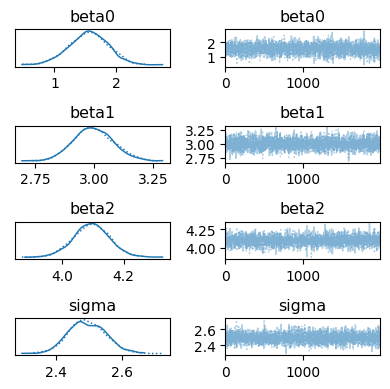

In [11]:
# ベイズ線形回帰モデルをサンプリング
with model:
    idata = pm.sample(
        chains=2,
        tune=1000, # バーンイン期間の、捨てるサンプル数
        draws=2000, # 採用するサンプル数
        random_seed=0,
    )

# 各chainsの結果を表示
az.plot_trace(idata, figsize=[4, 4])
plt.tight_layout()
plt.show()

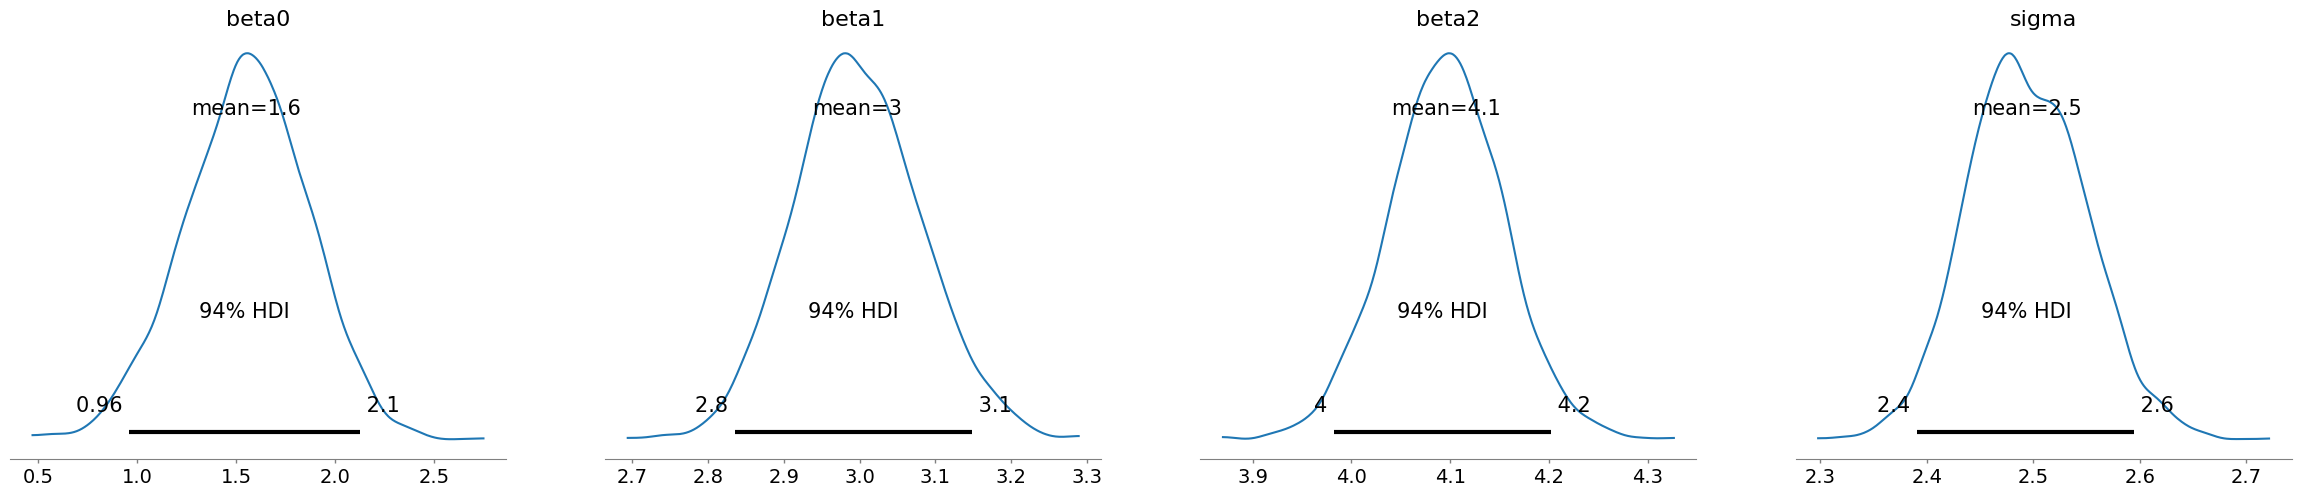

In [12]:
az.plot_posterior(idata)
plt.show()

### 不均一分散を想定したベイズ線形回帰（WIP）


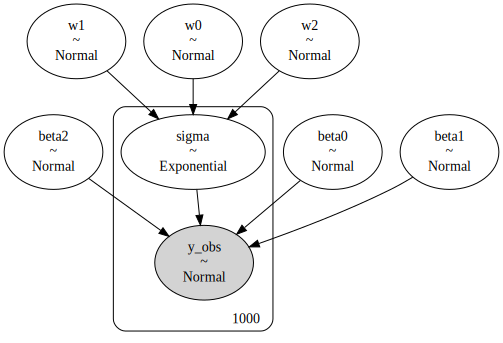

In [20]:
import pymc as pm
import arviz as az

model = pm.Model()
with model:
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    beta2 = pm.Normal("beta2", mu=0, sigma=1)

    # 誤差分散にも線形モデルを入れる
    w0 = pm.Normal("w0", mu=0, sigma=1)
    w1 = pm.Normal("w1", mu=0, sigma=1)
    w2 = pm.Normal("w2", mu=0, sigma=1)
    lam = pm.math.exp(w0 + w1 * X[:, 1] + w2 * X[:, 2])
    sigma = pm.Exponential("sigma", lam=lam)  # 分散なので非負の分布を使う

    # 平均値 mu
    mu = beta0 + beta1 * X[:, 1] + beta2 * X[:, 2]
    # 観測値をもつ確率変数は_obsとする
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

# モデルをGraphvizで表示
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, w0, w1, w2, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 198 seconds.
There were 844 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipykernel_18049/1400604983.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


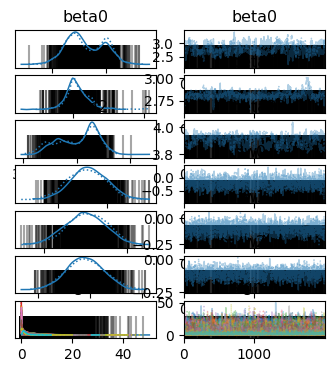

In [21]:
# ベイズ線形回帰モデルをサンプリング
with model:
    idata = pm.sample(
        chains=2,
        tune=1000, # バーンイン期間の、捨てるサンプル数
        draws=2000, # 採用するサンプル数
        random_seed=0,
    )

# 各chainsの結果を表示
az.plot_trace(idata, figsize=[4, 4])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1006) in plot_posterior, generating only 40 plots
  warnings.warn(


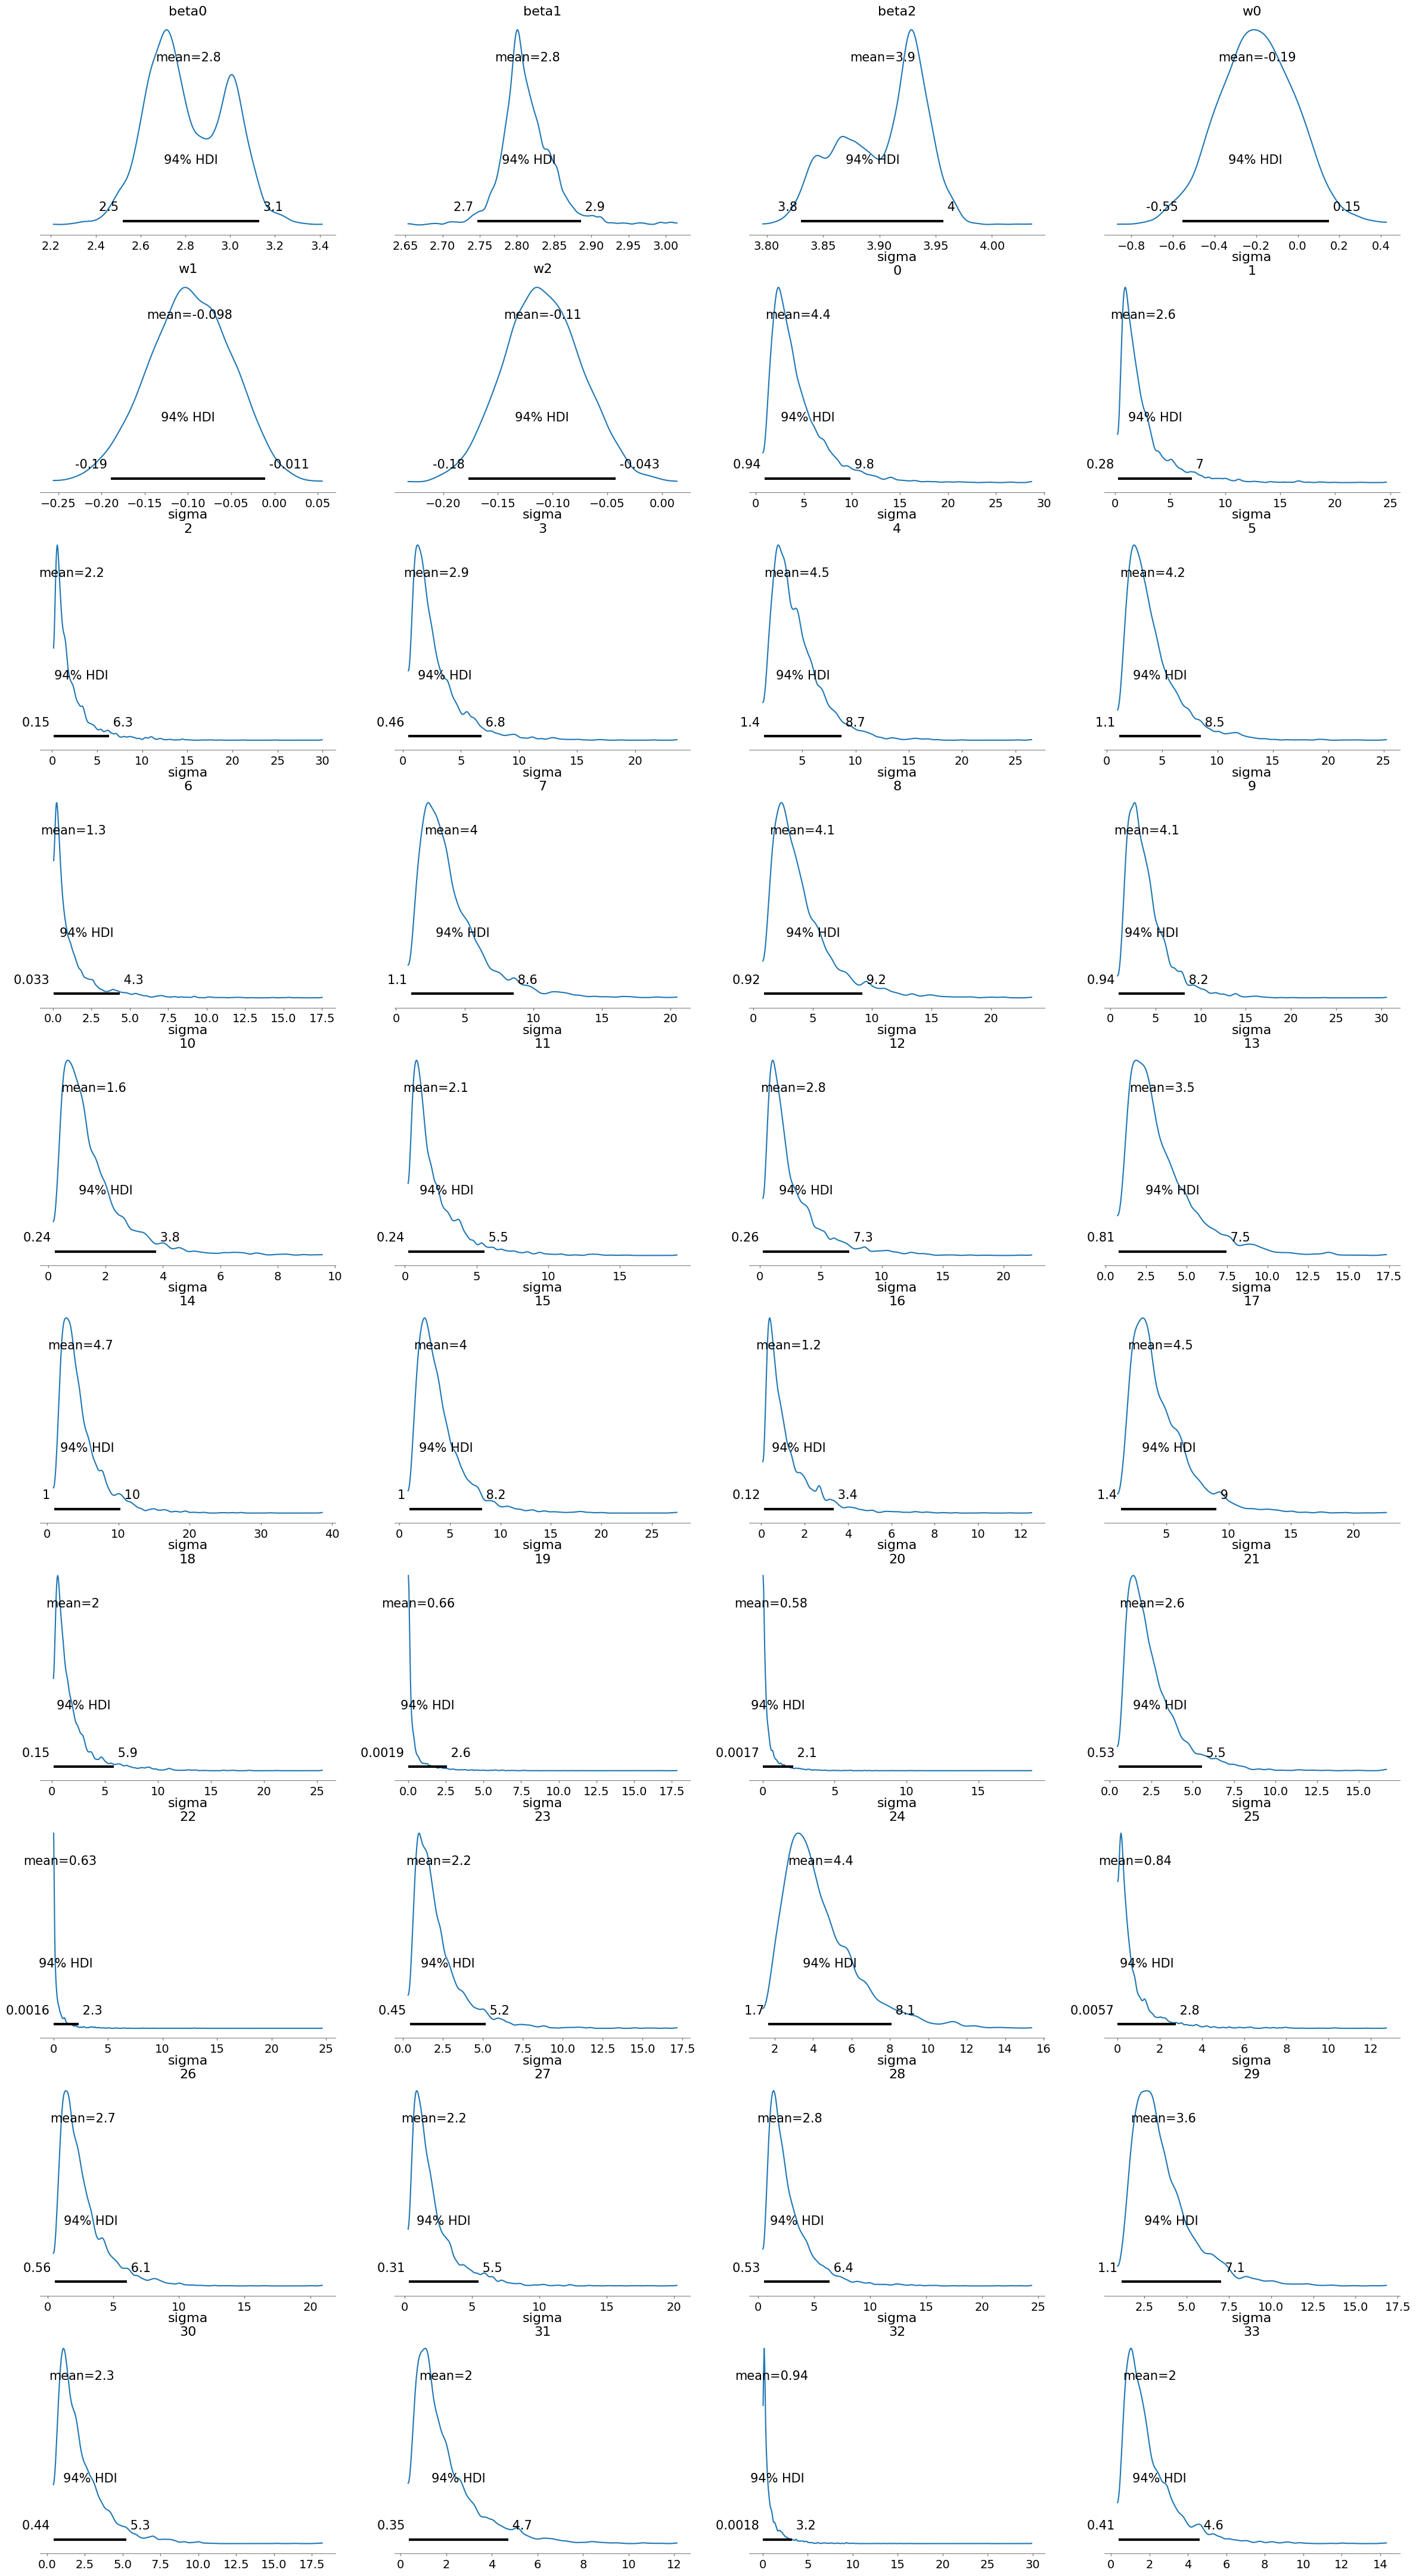

In [22]:
az.plot_posterior(idata)
plt.show()